In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
csv_file_path = 'wavelet_metrics.csv'  # Path to your CSV file
data = pd.read_csv(csv_file_path)

# Step 2: Separate features and labels
X = data.drop(['Data', 'label'], axis=1)  # Drop non-numeric and target columns
y = data['label']  # Extract labels (0 or 1)

# Step 3: Ensure equal class distribution in train and test sets
class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]

# Step 4: Split each class into 80% train and 20% test
train_0, test_0 = train_test_split(class_0, test_size=0.5, random_state=42)
train_1, test_1 = train_test_split(class_1, test_size=0.5, random_state=42)

# Step 5: Concatenate the training and testing data for both classes
train_data = pd.concat([train_0, train_1])
test_data = pd.concat([test_0, test_1])

# Step 6: Extract features and labels from the training and testing sets
X_train = train_data.drop(['Data', 'label'], axis=1)
y_train = train_data['label']
X_test = test_data.drop(['Data', 'label'], axis=1)
y_test = test_data['label']


In [16]:

# Step 7: Standardize the features
scaler = StandardScaler()
#scaler = StandardScaler(with_mean=True, with_std=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




Evaluating ICA with n_components=2
Fitting 10 folds for each of 143 candidates, totalling 1430 fits


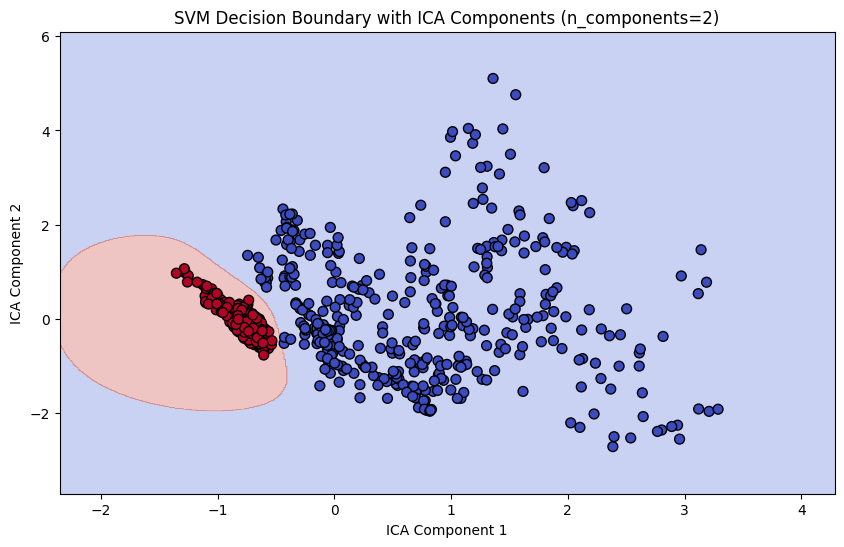

Best Parameters for n_components=2: {'C': 20, 'gamma': 1}
Confusion Matrix:
[[400   0]
 [  0 400]]
Sensitivity: 1.00, Specificity: 1.00, Accuracy: 1.00

ICA Components: 2, Accuracy: 1.00, Sensitivity: 1.00, Specificity: 1.00, Best Params: {'C': 20, 'gamma': 1}


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

# Initialize list to store results
results = []

# Define the SVM hyperparameters for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 2, 3, 5, 10, 20, 30, 40, 50, 100, 200],
    'gamma': [0.0001, 0.001, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1],
}

# Use StratifiedKFold for balanced cross-validation splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop over different n_components for ICA
for n in range(2, 3):  # Set n=2 for visualization in 2D
    print(f"\nEvaluating ICA with n_components={n}")
    
    # Apply ICA transformation
    ica = FastICA(n_components=n, random_state=0)
    X_train_ica = ica.fit_transform(X_train)
    X_test_ica = ica.transform(X_test)
    
    # Define the SVM with RBF kernel
    svm = SVC(kernel='rbf')
    
    # Perform GridSearchCV to find the optimal hyperparameters
    grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_ica, y_train)
    
    # Get the best model
    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train_ica, y_train)

    # Plot decision boundaries
    plt.figure(figsize=(10, 6))
    
    # Set the range for the grid
    x_min, x_max = X_train_ica[:, 0].min() - 1, X_train_ica[:, 0].max() + 1
    y_min, y_max = X_train_ica[:, 1].min() - 1, X_train_ica[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict for each point on the grid
    Z = best_svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_train_ica[:, 0], X_train_ica[:, 1], c=y_train, s=50, edgecolor='k', cmap='coolwarm')
    plt.xlabel('ICA Component 1')
    plt.ylabel('ICA Component 2')
    plt.title(f'SVM Decision Boundary with ICA Components (n_components={n})')
    plt.show()
    
    # Predict on the test set
    y_pred = best_svm.predict(X_test_ica)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate evaluation metrics
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print and store the results
    print(f"Best Parameters for n_components={n}: {grid_search.best_params_}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2f}")
    
    # Append results to list
    results.append({
        'n_components': n,
        'best_params': grid_search.best_params_,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy
    })

# Display all results
for result in results:
    print(f"\nICA Components: {result['n_components']}, "
          f"Accuracy: {result['accuracy']:.2f}, "
          f"Sensitivity: {result['sensitivity']:.2f}, "
          f"Specificity: {result['specificity']:.2f}, "
          f"Best Params: {result['best_params']}")
